# Проект по приоритизации маркетинговых гипотез и оценке результатов A/B-теста.

## Описание проекта 

Отдел маркетинга  скинул несколько гипотез, которые должны увеличить выручку нашего интернет-магазина.  
Наши задачи:
- приоритизировать гипотезы;
- запустить А/В-тест и проанализировать результаты;

Для работы нам дается 3 файла:
- файл с гипотезами
- файл с заказами
- файл с покупателями

## Знакомство с данными

### Предварительные настройки и подгрузка библиотек

Убираем предупреждения.

In [1]:
import warnings
warnings.filterwarnings('ignore')

Подгружаем библиотеки.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline
import scipy.stats as stats

Устанавливаем параметры по умолчанию.

In [3]:
pd.set_option('max_rows', 10)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.float_format', '{:.2f}'.format)

Подгружаем файлы.

In [4]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    hypothesis = pd.read_csv('hypothesis.csv')
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')

### Файл с гипотезами `/datasets/hypothesis.csv`
В данном файле перечисленны гипотезы, которые выдвинул отдел маркетинга. Каждая гипотеза имеет оценки показателей по 10-ти бальной шкале, требуемых для приоритизации гипотез методами ICE и RICE.
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [5]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
hypothesis.describe().T

,count,mean,std,min,25%,50%,75%,max
Reach,9.00,4.78,3.15,1.00,3.00,3.00,8.00,10.00
Impact,9.00,4.78,3.19,1.00,3.00,3.00,7.00,10.00
Confidence,9.00,5.56,3.05,1.00,3.00,7.00,8.00,9.00
Efforts,9.00,4.89,2.80,1.00,3.00,5.00,6.00,10.00


#### Краткий вывод
Датасет требует предварительную обработку в виде изменения названия полей.

### Файл с заказами `/datasets/orders.csv`
В данном файле перечислены заказы пользователей. Для каждого заказа присутствует уникальный ID, уникальный ID посетителя, дата заказа, сумма заказа и к какой группе относится пользователь при А/В-тестировании.
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

In [8]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
orders.describe().T

,count,mean,std,min,25%,50%,75%,max
transactionId,1197.00,2155621385.53,1229084904.76,1062393.00,1166775572.00,2145193898.00,3237740112.00,4293855558.00
visitorId,1197.00,2165960143.10,1236014192.15,5114589.00,1111826046.00,2217984702.00,3177606451.00,4283872382.00
revenue,1197.00,8348.01,39191.13,50.00,1220.00,2978.00,8290.00,1294500.00


Проверим период, за который мы имеем данные. Сперва приведем данные в формат даты.

In [11]:
orders.date = pd.to_datetime(orders.date)
orders.date.dtype

dtype('<M8[ns]')

Далее проверим период, за который представлены данные.

In [12]:
orders.date.min()

Timestamp('2019-08-01 00:00:00')

In [13]:
orders.date.max()

Timestamp('2019-08-31 00:00:00')

Проверим, есть ли пользователи, которые относятся к обеим группам.

In [14]:
group_a = orders.query('group == "A"')['visitorId'].tolist()
group_b = orders.query('group == "B"')['visitorId'].tolist()

In [15]:
a_from_b = orders.query('(group == "A") & (visitorId in @group_b)')
print(f'Кол-во заявок пользователей B, учтенных как A: {a_from_b.revenue.count()}')
print(f'Выручка: {a_from_b.revenue.sum()}')

Кол-во заявок пользователей B, учтенных как A: 89
Выручка: 720147


In [16]:
b_from_a = orders.query('(group == "B") & (visitorId in @group_a)')
print(f'Кол-во заявок пользователей A, учтенных как B: {b_from_a.revenue.count()}')
print(f'Выручка: {b_from_a.revenue.sum()}')

Кол-во заявок пользователей A, учтенных как B: 92
Выручка: 838788


Мы можем наблюдать, что в выборке присутствуют заказы неправильно распределенные по группам. Но таких заказов приблизительно равное количество в обеих группах и их суммарная выручка так же не сильно отличается. По этой причине этим можно принебречь.

#### Краткий вывод
Данные представлены за август 2019 года. В поле `revenue` присутствуют аномальные значения.  
Датасет требует дополнительно обработки в виде:
- изменения названия полей;
- проверка на полные дупликаты;

### Файл с покупателями `/datasets/visitors.csv`
Файл содержит информацию о количестве посетителей сайта в каждый из дней за некий период. В файле содержится информация о дате, группе из А/В-теста и кол-во посетителей в данный день.
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

In [17]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [18]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [19]:
visitors.describe().T

,count,mean,std,min,25%,50%,75%,max
visitors,62.00,607.29,114.40,361.00,534.00,624.50,710.50,770.00


Приведем дату к нужному формату и проверим период, за который представлены данные.

In [20]:
visitors.date = pd.to_datetime(visitors.date)
visitors.date.dtype

dtype('<M8[ns]')

In [21]:
visitors.date.min()

Timestamp('2019-08-01 00:00:00')

In [22]:
visitors.date.max()

Timestamp('2019-08-31 00:00:00')

#### Краткий вывод
Данные представлены за август 2019 года. Датасет потребует обработку в виде:
- проверка полных дупликатов;

### Вывод по разделу
- Для проверки имеются 9 гипотез.
- Данные по заказам и посетителям представлены за август 2019 года.
- Пропусков нет.
- Данные представлены в хорошем виде, требуются минимальные обработки для работы с датасетами. 
- Данных достаточно для проведения исследования.

## Предобработка данных

### Датасет `hypothesis`

Посмотрим на датасет.

In [23]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Приведем названия полей к нижнему регистру.

In [24]:
hypothesis.columns = [c_name.lower().replace(' ', '_') for c_name in hypothesis.columns]

In [25]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Датасет `orders`

Посмотрим на датасет.

In [26]:
orders.sample(5)

,transactionId,visitorId,date,revenue,group
967,1126236755,4228915420,2019-08-10,2348,B
45,837819976,1471496742,2019-08-16,2140,A
65,2321477056,2868887864,2019-08-16,1710,B
452,3367644853,2307676173,2019-08-06,5270,B
832,2470658885,3766097110,2019-08-30,360,B


Поменяем названия полей.

In [27]:
orders = orders.rename(columns={
    'transactionId': 'transaction_id',
    'visitorId': 'visitor_id'
})
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Проверим на дупликаты.

In [28]:
orders.duplicated().sum()

0

### Датасет `visitors`

Посмотрим на датасет.

In [29]:
visitors.sample(5)

,date,group,visitors
11,2019-08-12,A,595
10,2019-08-11,A,718
41,2019-08-11,B,721
43,2019-08-13,B,769
9,2019-08-10,A,406


Проверим на дупликаты.

In [30]:
visitors.duplicated().sum()

0

### Вывод по разделу

Как и предполагалось, данные потребовали минимальной предобработки. В основном она свелась к поиску дупликатов и изменению названий полей. В датасете `orders` были найдены аномально быльшие значения в поле `revenue`, часть из них мы исключили из выборки, удалив 5% самых дорогих заказов. Так же мы исключили пользователей с кол-вом заказов более 5.

## Проверка гипотез

### Знакомство с гипотезами

Посмотрим еще раз на наши гипотезы.

In [31]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Учитывая, что в таблице пристуствует `efforts`, формула для вычисления ICE будет выглядеть как:  
(`impact` * `confidence`) / `efforts`  
  
RICE будем вычислять по формуле:  
(`reach` * `impact` * `confidence`) / `efforts`
  
- `reach` — скольких пользователей затронет изменение, которое вы хотите внести;
- `impact` — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- `confidence` — насколько вы уверены, что это изменение повлияет на пользователей именно так;
- `efforts` — сколько стоит протестировать эту гипотезу.

### Приоритизация гипотез

#### Применим фреймворк ICE для приоритизации гипотез

Создадим новое поле и запишем в него результаты вычисления методом ICE.

In [32]:
hypothesis['ICE'] = (
    (hypothesis.impact * hypothesis.confidence) / hypothesis.efforts
)
hypothesis = hypothesis.sort_values(by='ICE', ascending=False)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Победителем оказались гипотезы, по приоритету:
- 8 - Запустить акцию, дающую скидку на товар в день рождения	
- 0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
- 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

#### Применим фреймворк RICE для приоритизации гипотез

Создадим новое поле и запишем в него результаты вычисления методом RICE.

In [33]:
hypothesis['RICE'] = (
    (hypothesis.impact * hypothesis.confidence * hypothesis.reach) / hypothesis.efforts
)
hypothesis = hypothesis.sort_values(by='RICE', ascending=False)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


Победителем оказались гипотезы, по приоритету:
- 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок		
- 2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
- 0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	

### Сравниваем результаты ICE и RICE

Как мы знаем, различия между фреймворками ICE и RICE заключаются в допольнительном показателе, отвечающем за охват пользователей. Таким образом даже самая отличная идея может отойти на второй план, если она затрагивает небольшую группу людей(это не относится к повышению ЗП топ-менеджеров). Посмотрим еще раз на список приоритетов по ICE.

In [34]:
hypothesis.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


По первому столбцу `reach`, мы видим, что размер охвата у лучших гипотез по ICE, идет по нарастанию. Что говорит нам о том, что охват пользователей у "лучшей" гипотезы будет самым маленьким. Именно поэтому RICE показал другие результаты.

In [35]:
cm = sns.color_palette("coolwarm", as_cmap=True)
hypothesis.sort_values(by='RICE', ascending=False).style.background_gradient(cmap = cm,axis=0)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.000000


### Вывод по разделу
Мы проверили приоритетность гипотез с помощью фреймворков ICE и RICE. Фреймворки показали разные результаты.  

---
ICE:
- 8 - Запустить акцию, дающую скидку на товар в день рождения	
- 0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
- 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	
  
RICE:
- 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок		
- 2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
- 0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
  
Причина различия результатов кроется в показателе `reach`, отвечающем за охват пользователей. Фреймворк ICE его не учитывает.

## Анализ A/B-теста

Для начала объединим данные из датасетов `orders` и `visitors`.  
Начнем с датасета `visitors`.

### Подготовка к анализу

Создадим таблицу с кумулятивным приростом посетителей.

In [36]:
visitors_cummulative = (
    visitors
    .apply(lambda x: visitors.query('(date <= @x.date) & (group == @x.group)')
           .agg({
               'date': 'max',
               'group': 'max',
               'visitors': 'sum'
           }), axis=1)
    .sort_values(by=['date', 'group']))
visitors_cummulative.columns = ['date', 'group', 'visitors_cmltv']

In [37]:
visitors_cummulative.head(4)

,date,group,visitors_cmltv
0,2019-08-01,A,719
31,2019-08-01,B,713
1,2019-08-02,A,1338
32,2019-08-02,B,1294


Далее так же обработаем заказы. Сперва найдем кол-во заказов в день.

In [38]:
orders_daily = (
    visitors
    .apply(lambda x: orders.query('(date <= @x.date) & (group == @x.group)')
           .agg({
               'date': 'max',
               'group': 'max',
               'transaction_id': 'nunique',
               'visitor_id': 'nunique',
               'revenue': 'sum'
           }), axis=1)
    .sort_values(by=['date', 'group']))
orders_daily.columns = ['date', 'group', 'transactions_cmltv', 'buyers_cmltv', 'revenue_cmltv']

In [39]:
orders_daily.head(4)

,date,group,transactions_cmltv,buyers_cmltv,revenue_cmltv
0,2019-08-01,A,24,20,148579
31,2019-08-01,B,21,20,101217
1,2019-08-02,A,44,38,242401
32,2019-08-02,B,45,43,266748


Объединим обе таблицы.

In [40]:
data_cmltv = visitors_cummulative.merge(orders_daily, on=['date', 'group'])
data_cmltv.date = data_cmltv.date.dt.date
data_cmltv.head()

,date,group,visitors_cmltv,transactions_cmltv,buyers_cmltv,revenue_cmltv
0,2019-08-01,A,719,24,20,148579
1,2019-08-01,B,713,21,20,101217
2,2019-08-02,A,1338,44,38,242401
3,2019-08-02,B,1294,45,43,266748
4,2019-08-03,A,1845,68,62,354874


С этим уже можно работать, начнем наш анализ.

### График кумулятивной выручки по группам

Сперва построим график кумулятивной выручки по группам.

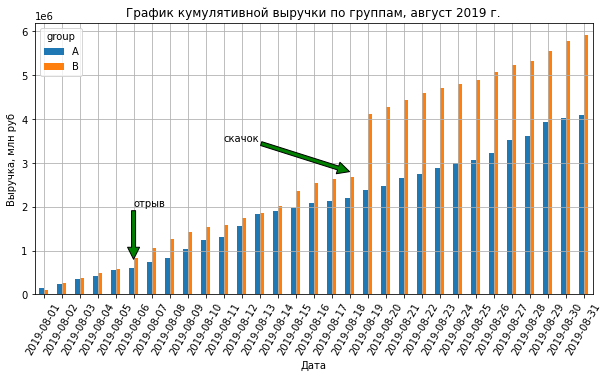

In [41]:
(data_cmltv
 .pivot_table(
     index='date',
     columns='group',
     values='revenue_cmltv')
 .plot(
     kind='bar',
     figsize=(10, 5),
     grid=True,
     title='График кумулятивной выручки по группам, август 2019 г.')
 )
plt.xlabel('Дата')
plt.ylabel('Выручка, млн руб')
plt.xticks(rotation=60)
plt.annotate('скачок', xy=(17, 2800000), xytext=(10, 3500000),
             arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=(5, 800000), xytext=(5, 2000000),
             arrowprops=dict(facecolor='g'))
plt.show()

#### Краткий вывод
- динамика прироста выручки по группе В выше чем по группе А;
- спустя 18 дней после начала теста группа В резко вырывается вперед;
- 13 августа группа А практически сравнялась с группой В;
- скорее всего на результаты повлиял крупный заказ в группе В 19 августа, т.к. далее динамика прироста выручки не была такой резкой;

### График кумулятивного среднего чека по группам

Для подсчета среднего чека добавим новый столбец.

In [42]:
data_cmltv['mean_check'] = (
    data_cmltv.revenue_cmltv / data_cmltv.transactions_cmltv
)
data_cmltv.head(4)

,date,group,visitors_cmltv,transactions_cmltv,buyers_cmltv,revenue_cmltv,mean_check
0,2019-08-01,A,719,24,20,148579,6190.79
1,2019-08-01,B,713,21,20,101217,4819.86
2,2019-08-02,A,1338,44,38,242401,5509.11
3,2019-08-02,B,1294,45,43,266748,5927.73


Посмотрим на график.

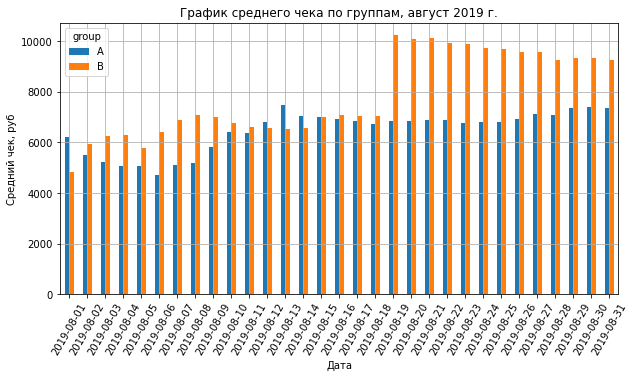

In [43]:
(data_cmltv
 .pivot_table(
     index='date',
     columns='group',
     values='mean_check')
 .plot(
     kind='bar',
     figsize=(10, 5),
     grid=True,
     title='График среднего чека по группам, август 2019 г.')
 )
plt.xlabel('Дата')
plt.ylabel('Средний чек, руб')
plt.xticks(rotation=60);

#### Краткий вывод
- На графике мы видим скачки в изменении среднего чека;
- Самый большой скачек мы можем наблюдать 19 августа, что подтверждает нашу гипотезу о покупателе с дорогой покупкой;

### График относительного изменения кумулятивного среднего чека группы B к группе A

Сперва создадим сводную таблицу.

In [44]:
mean_check_b_to_a = data_cmltv.pivot_table(
    index='date', columns='group', values='mean_check')

Далее добавим новый столбец с разницей между средним чеком групп.

In [45]:
mean_check_b_to_a['b_to_a'] = mean_check_b_to_a.B / mean_check_b_to_a.A - 1

Пора строить график.

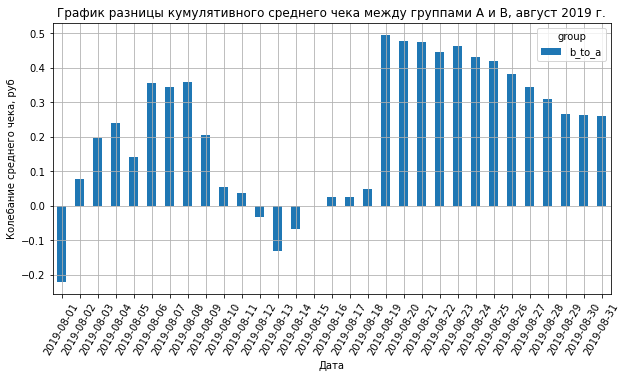

In [46]:
(mean_check_b_to_a[['b_to_a']]
    .plot(
        kind='bar',
        figsize=(10,5), 
        title='График разницы кумулятивного среднего чека между группами А и В, август 2019 г.', 
        grid=True)
)
plt.xlabel('Дата')
plt.ylabel('Колебание среднего чека, руб')
plt.xticks(rotation=60);

#### Краткий вывод
- динамика кумулятивного прироста среднего чека сильно колеблется в сторону группы В;
- по динамике колебаний абсолютное первенство за группой В, но все еще это может быть за счет покупателя с чеком намного превышающим средние значения;

### График кумулятивной конверсии по группам

Добавим в наш основной датасет новый столбец с конверсией.

In [47]:
data_cmltv['conversion'] =  data_cmltv.buyers_cmltv / data_cmltv.visitors_cmltv

In [48]:
data_cmltv.head(4)

,date,group,visitors_cmltv,transactions_cmltv,buyers_cmltv,revenue_cmltv,mean_check,conversion
0,2019-08-01,A,719,24,20,148579,6190.79,0.03
1,2019-08-01,B,713,21,20,101217,4819.86,0.03
2,2019-08-02,A,1338,44,38,242401,5509.11,0.03
3,2019-08-02,B,1294,45,43,266748,5927.73,0.03


Строим график.

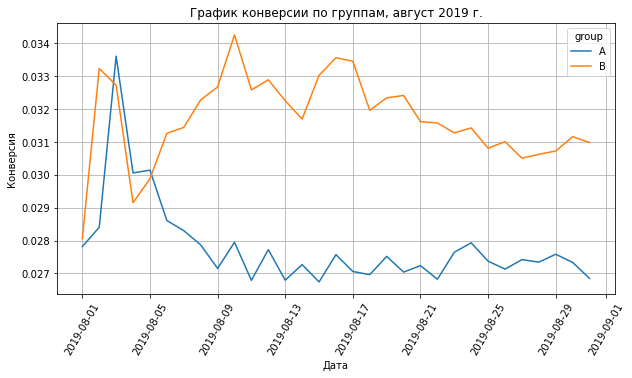

In [49]:
(data_cmltv
 .pivot_table(
     index='date',
     columns='group',
     values='conversion')
 .plot(
     figsize=(10, 5),
     grid=True,
     title='График конверсии по группам, август 2019 г.')
 )
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.xticks(rotation=60);

#### Краткий вывод
- первые несколько дней конверсия была похожа;
- начиная с 5 августа группа В показывает лучшую конверсия, чем группа В;
- в конце тестирования группа А закрепилась на уровне 2,7% конверсии, а группа В - 3,1%;

### График относительного изменения кумулятивной конверсии группы B к группе A

Создаем сводную таблицу.

In [50]:
conversion_b_to_a = (data_cmltv
                     .pivot_table(
                         index='date',
                         columns='group',
                         values='conversion'))

Находим изменение.

In [51]:
conversion_b_to_a['b_to_a'] = conversion_b_to_a.B / conversion_b_to_a.A - 1

Рисуем график.

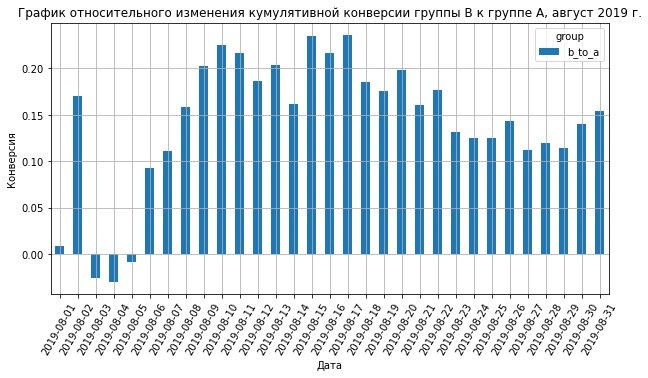

In [52]:
(conversion_b_to_a[['b_to_a']]
    .plot(
        kind='bar',
        figsize=(10,5), 
        title='График относительного изменения кумулятивной конверсии группы B к группе A, август 2019 г.', 
        grid=True)
)
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.xticks(rotation=60);

#### Краткий вывод
- группа В, если не брать начало теста, показывает стабильно лучшую конверсию по сравнению с А;
- конверсия группы В выше группы А на 15% под конец теста;

### Точечный график количества заказов по пользователям

Проверим какое кол-во заказов приходится на одного пользователя.

In [53]:
orders_by_user = (
    orders
    .groupby('visitor_id')
    .agg({'transaction_id':'count'})
).sort_values(by='transaction_id', ascending=False)

Построим график по получившимся данным.

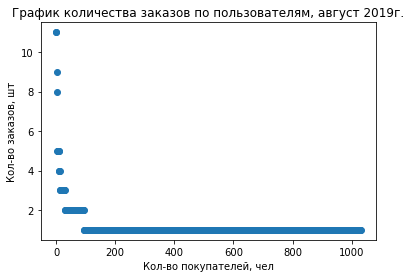

In [54]:
orders_values = pd.Series(range(0, len(orders_by_user.transaction_id)))
plt.scatter(
    orders_values,
    orders_by_user.transaction_id
)
plt.title('График количества заказов по пользователям, август 2019г.')
plt.xlabel('Кол-во покупателей, чел')
plt.ylabel('Кол-во заказов, шт');

#### Краткий вывод
- большая часть покупателей за месяц сделала не более одного заказа, но есть и аномальные пользователи с 11 заказами;
- реже покупатели делают 2 заказа;

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

Сперва посмотрим через метод, а потом применим функцию.

In [55]:
def rare_values(df):
    numerics = (['int8', 'int16', 'int32', 'int64', 
                 'uint8', 'uint16', 'uint32', 'uint64',
                 'float16', 'float32', 'float64'])
    if isinstance(df, pd.Series):
        df = df.to_frame()
    df_test = df.select_dtypes(include=numerics)   
    for col in df_test.columns:
        q1 = df_test[col].quantile(0.25)
        q3 = df_test[col].quantile(0.75)
        p95 = int(df_test[col].quantile(0.95))
        p99 = int(df_test[col].quantile(0.99))
        p_max = df_test[col].max()
        iqr = q3 - q1
        bot_border = q1 - iqr*1.5
        top_border = q3 + iqr*1.5
        rare_values_bot = df.query(f'{col} < @bot_border')[col].count()
        rare_values_top = df.query(f'{col} > @top_border')[col].count()
        print (f'Колонка - {col}\n'
                f'Первый квартиль = {q1}\n'
                f'Третий квартиль = {q3}\n'
                f'Значение 95% = {p95}\n'
                f'Значение 99% = {p99}\n'
                f'Максимальное значение = {p_max}\n'
                f'Нижняя граница = {bot_border}, Верхняя граница = {top_border}\n'
                f'Редкие значения меньше нижней границы = {rare_values_bot}\n'
                f'Редкие значения больше верхней границы = {rare_values_top}\n'
              )

In [56]:
orders_by_user.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction_id,1031.00,1.16,0.72,1.00,1.00,1.00,1.00,11.00


In [57]:
rare_values(orders_by_user)

Колонка - transaction_id
Первый квартиль = 1.0
Третий квартиль = 1.0
Значение 95% = 2
Значение 99% = 4
Максимальное значение = 11
Нижняя граница = 1.0, Верхняя граница = 1.0
Редкие значения меньше нижней границы = 0
Редкие значения больше верхней границы = 94



In [58]:
orders_by_user_active = orders_by_user.query('transaction_id > 2')
print(f"Количество строк: {orders_by_user_active.count()}")
print(f"Количество заказов: {orders_by_user_active.sum()}")

Количество строк: transaction_id    30
dtype: int64
Количество заказов: transaction_id    132
dtype: int64


In [59]:
orders_by_user_active = orders_by_user.query('transaction_id > 4')
print(f"Количество строк: {orders_by_user_active.count()}")
print(f"Количество заказов: {orders_by_user_active.sum()}")

Количество строк: transaction_id    10
dtype: int64
Количество заказов: transaction_id    69
dtype: int64


Выбирая между удалением из выборки 5% или 1%, я больше склоняюсь ко второму варианту, т.к. удаление 132 заказов может сильно повлиять на результаты выборки.

In [60]:
orders_clear = orders.query(
    'visitor_id not in @orders_by_user_active.index'
)

In [61]:
orders_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1128 non-null   int64         
 1   visitor_id      1128 non-null   int64         
 2   date            1128 non-null   datetime64[ns]
 3   revenue         1128 non-null   int64         
 4   group           1128 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 52.9+ KB


Таким образом мы превратили выборку из 1197 строк в выборку и 1128 строк.

#### Краткий вывод
- анализируя аномальные выбросы в кол-ве заказов на пользователя, мы приняли решение удалить 1% покупателей с самым большим кол-вом заказов;

### Точечный график стоимостей заказов

Проверим разброс значений в поле `revenue`.

In [62]:
orders.revenue.describe()

count      1197.00
mean       8348.01
std       39191.13
min          50.00
25%        1220.00
50%        2978.00
75%        8290.00
max     1294500.00
Name: revenue, dtype: float64

Очевидно, что максимальное значение слишком сильно отличается от среднего. Проверим как распределены значения на графике.

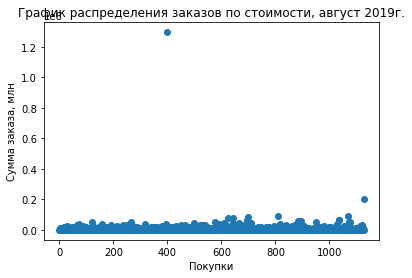

In [63]:
revenue_values = pd.Series(range(0, len(orders_clear.revenue)))
plt.scatter(
    revenue_values, 
    orders_clear.revenue
)
plt.title('График распределения заказов по стоимости, август 2019г.')
plt.ylabel('Сумма заказа, млн')
plt.xlabel('Покупки');

#### Краткий вывод
- Большая часть покупок совершено на сумму до 100 000 руб., но есть несколько аномалий;

### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [64]:
orders_clear.revenue.describe()

count      1128.00
mean       8362.02
std       40253.94
min          50.00
25%        1190.00
50%        2970.00
75%        8392.75
max     1294500.00
Name: revenue, dtype: float64

Используем ту же функцию, что и ранее.

In [65]:
rare_values(orders_clear.revenue)

Колонка - revenue
Первый квартиль = 1190.0
Третий квартиль = 8392.75
Значение 95% = 27582
Значение 99% = 57295
Максимальное значение = 1294500
Нижняя граница = -9614.125, Верхняя граница = 19196.875
Редкие значения меньше нижней границы = 0
Редкие значения больше верхней границы = 102



Мы видим, что максимальное значение среди 95% пользователей отличается от максимума в 5 раз.  
Попробуем построить график.

У нас есть несколько значений, которые сильно отличаются от остальных. Очевидно, что имеет смысл исключить их из выборки для чистоты анализа. Возьмем за норму заказы ниже границы в 95%.

In [66]:
orders_clear_filtered = orders_clear.query('revenue >= 27582')
print(f"Количество строк: {orders_clear_filtered.revenue.count()}")
print(f"Выручка: {orders_clear_filtered.revenue.sum()}")

Количество строк: 57
Выручка: 3935612


In [67]:
orders_clear_filtered = orders_clear.query('revenue >= 57295')
print(f"Количество строк: {orders_clear_filtered.revenue.count()}")
print(f"Выручка: {orders_clear_filtered.revenue.sum()}")

Количество строк: 12
Выручка: 2247380


В данном случае я так же склоняюсь к удалению 1% выборки, что будет составлять 12 заказов на сумму 2 247 380 руб.

In [68]:
order_clear = orders_clear.query('revenue >= 57295')

#### Краткий вывод
- анализируя аномальные выбросы в стоимости одного заказа, мы приняли решение удалить 1% покупателей;
- 1% заказов - это 12 заказов на сумму 2 247 380 руб.

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

Создадим таблицы с количеством заказов на пользователя с разбивкой по группам.

In [69]:
orders_by_users_a = (
    orders.query('group == "A"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_a.columns = ['user_id', 'transactions']

orders_by_users_b = (
    orders.query('group == "B"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_b.columns = ['user_id', 'transactions']

Создадим выборку, где каждый элемент — число заказов определённого пользователя.

In [70]:
sample_a = pd.concat([
    orders_by_users_a['transactions'],
    pd.Series(
        0,
        index=np.arange(
            visitors.query('group == "A"')['visitors'].sum(
            ) - len(orders_by_users_a['transactions'])
        ),
        name='orders',
    ),
],
    axis=0,
)

sample_b = pd.concat([
    orders_by_users_b['transactions'],
    pd.Series(
        0,
        index=np.arange(
            visitors.query('group == "B"')['visitors'].sum(
            ) - len(orders_by_users_b['transactions'])
        ),
        name='orders',
    ),
],
    axis=0,
)

Выведем относительный прирост конверсии группы B по отнашению к A по "сырым" данным.

### Гипотезы
- Нулевая гипотеза: статистически значимых различий в конверсии между группами нет.  
- Обратная гипотеза: статистически значимые различия в конверсии между группами есть.

In [71]:
print("{0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print("{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

0.017
0.138


#### Крайткий вывод
Первое число — `p-value` = 0.017 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, не отвергаем. Однако относительный проигрыш группы B равен 14% — второе число в выводе.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [72]:
print('{0:.3f}'
      .format(
          stats.mannwhitneyu(
              orders.query('group == "A"').revenue, 
              orders.query('group == "B"').revenue
          )[1]))
print('{0:.3f}'
      .format(
          orders.query('group == "B"').revenue.mean() / 
          orders.query('group == "A"').revenue.mean() - 1
      )
     )

0.729
0.259


#### Краткий вывод
P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом, средний чек группы A значительно ниже среднего чека группы B.

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным

Делаем все то же самое, что и с сырыми данными.

In [73]:
orders_by_users_a_clear = (
    orders_clear.query('group == "A"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_a_clear.columns = ['user_id', 'transactions']

orders_by_users_b_clear = (
    orders_clear.query('group == "B"')
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users_b_clear.columns = ['user_id', 'transactions']

In [74]:
sample_a_clear = pd.concat(
    [
        orders_by_users_a_clear['transactions'],
        pd.Series(
            0,
            index=np.arange(
                visitors.query('group == "A"')['visitors'].sum() - len(orders_by_users_a_clear['transactions'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_clear = pd.concat(
    [
        orders_by_users_b_clear['transactions'],
        pd.Series(
            0,
            index=np.arange(
                visitors.query('group == "B"')['visitors'].sum() - len(orders_by_users_b_clear['transactions'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Посмотрим на результат.

In [75]:
print("{0:.3f}".format(stats.mannwhitneyu(sample_a_clear, sample_b_clear)[1]))

print("{0:.3f}".format(sample_b_clear.mean() / sample_a_clear.mean() - 1))

0.016
0.150


#### Крайткий вывод
Первое число — `p-value` = 0.016 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, можем отвергнуть. При этом относительный проигрыш группы B равен 15% — второе число в выводе.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Делаем все то же самое, что и с сырыми данными.

In [76]:
print('{0:.3f}'
      .format(
          stats.mannwhitneyu(
              orders_clear.query('group == "A"').revenue, 
              orders_clear.query('group == "B"').revenue
          )[1]))
print('{0:.3f}'
      .format(
          orders_clear.query('group == "B"').revenue.mean() / 
          orders_clear.query('group == "A"').revenue.mean() - 1
      )
     )

0.899
0.238


#### Краткий вывод
P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом, средний чек группы A значительно ниже среднего чека группы B.

### Вывод по разделу
- На протяжении всего теста группа B показывала лучшие результаты в плане выручки, частично это объясняется аномальными покупателями покупателями;
- Средний чек у группы B так же выше;
- Конверсия между группами так же показала лучшие результаты для группы B;

## Общий вывод
Для проведения нам были предоставлены данные из трех таблиц:
- Гипотезы для проверки;
- Заказы групп из А/В-теста за август 2019 года;
- Общее кол-во заказов ежедневно по каждой из групп в августе 2019 года.

В целом данные в хорошем состоянии, существуют пересечения по пользователям, но пересечения в обеих группах приблизительно уровеновешивают друг друга по кол-ву заказов и выручке, поэтому ими можно принебречь.

---

В данной работе мы провели два отдельных друг от друга иследования:
- Мы проверили приоритетность гипотез с помощью фреймворков ICE и RICE; 
- Мы проверили результаты анализа A/B-теста;

---
ICE:
- 8 - Запустить акцию, дающую скидку на товар в день рождения	
- 0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
- 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	
  
RICE:
- 7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок		
- 2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	
- 0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
  
---

- На протяжении всего теста группа B показывала лучшие результаты в плане выручки, частично это объясняется аномальными покупателями покупателями;
- Средний чек у группы B так же выше;
- Конверсия между группами так же показала лучшие результаты для группы B;

---

Результатом исследование является решение остановить A/B-тест и признать победу группы из выборки B. Учитывая, рост конверсии в группе, мы можем преположить увеличения кол-ва заказов.